# Task 1: Acquire, Preproess and Analyze Data


## Import libraries and data



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 100)

In [2]:
searchTrendData = pd.read_csv("https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/search_trends_symptoms_dataset/United%20States%20of%20America/2020_US_weekly_symptoms_dataset.csv")
hospitalizationData = pd.read_csv("https://raw.githubusercontent.com/google-research/open-covid-19-data/master/data/exports/cc_by/aggregated_cc_by.csv")

/opt/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean the Dataframe

There are columns in the dataframe where the whole column contains nothing but NaN, 
so these columns need to be dropped. 

Then there are columns that contains a large
amount of NaNs. These should be dropped too once the amount of NaN reaches a certain
threshold. Several experimentation were performed to decide the best value for this
threshold. The higher the threshold, the more columns dropped. 

In [3]:
## drop all NaN columns for searchTrendData
searchTrendData = searchTrendData.dropna('columns', 'all')
## drop column if it doesn't have at least 60% of non-NaN values
searchTrendData = searchTrendData.dropna(axis = "columns", thresh = (int) (searchTrendData.shape[0] * 0.6))

## drop all data that is not from the US
hospitalizationData = hospitalizationData[hospitalizationData['open_covid_region_code'].str.contains('US-')]
## drop all NaN columns for hospitalizationData
hospitalizationData = hospitalizationData.dropna('columns', 'all')
## drop the column if it doesn't have at least 30% of non-Nan values 
hospitalizationData = hospitalizationData.dropna(axis = "columns", thresh = (int) (hospitalizationData.shape[0] * 0.3))

Merge two dataset

In [4]:
## debug cell, delete when assignment is finished
searchTrendData
len(searchTrendData[searchTrendData['open_covid_region_code'] == 'US-WY'])

39

In [5]:
# searchTrendData.iloc[7:10, :]

In [6]:
## debug cell, delete when assignment is finished
hospitalizationData['date'] = pd.to_datetime(hospitalizationData['date'])
hospitalizationData['date'] = hospitalizationData['date'] - pd.to_timedelta(hospitalizationData['date'].dt.weekday, unit='D')
## Feiyang Li --> Once you changed hospitalization data to weekly resolution, there are many duplicates. Let's drop them
## and see how it works
## 
hospitalizationData = hospitalizationData.drop_duplicates();
hospitalizationData

,open_covid_region_code,region_name,date,hospitalized_new,hospitalized_cumulative
85278,US-WY,Wyoming,2020-03-02,0.0,0.0
85280,US-WY,Wyoming,2020-03-09,0.0,0.0
85287,US-WY,Wyoming,2020-03-16,0.0,0.0
85294,US-WY,Wyoming,2020-03-23,0.0,0.0
85298,US-WY,Wyoming,2020-03-23,11.0,11.0
...,...,...,...,...,...
97499,US-AK,Alaska,2020-09-07,0.0,0.0
97506,US-AK,Alaska,2020-09-14,0.0,0.0
97513,US-AK,Alaska,2020-09-21,0.0,0.0
97520,US-AK,Alaska,2020-09-28,0.0,0.0


In [7]:
hospitalizationData
# len(hospitalizationData[hospitalizationData['open_covid_region_code'] == 'US-WY'])

,open_covid_region_code,region_name,date,hospitalized_new,hospitalized_cumulative
85278,US-WY,Wyoming,2020-03-02,0.0,0.0
85280,US-WY,Wyoming,2020-03-09,0.0,0.0
85287,US-WY,Wyoming,2020-03-16,0.0,0.0
85294,US-WY,Wyoming,2020-03-23,0.0,0.0
85298,US-WY,Wyoming,2020-03-23,11.0,11.0
...,...,...,...,...,...
97499,US-AK,Alaska,2020-09-07,0.0,0.0
97506,US-AK,Alaska,2020-09-14,0.0,0.0
97513,US-AK,Alaska,2020-09-21,0.0,0.0
97520,US-AK,Alaska,2020-09-28,0.0,0.0


In [8]:
## change dates to weekly represented dates
hospitalizationData['date'] = pd.to_datetime(hospitalizationData['date'])
hospitalizationData['date'] = hospitalizationData['date'] - pd.to_timedelta(hospitalizationData['date'].dt.weekday, unit='D')

## drop the hospitalized_culumative column since it doesn't make since to merge them into a weekly entry
hospitalizationData = hospitalizationData.drop('hospitalized_cumulative', axis = 1)

## combine all data with the same region code, and the same date
## find all unique dates and regions
region_codes = hospitalizationData['open_covid_region_code'].unique()

result_df = pd.DataFrame()
## group all rows with the same region code
for code in region_codes:
    region_rows = hospitalizationData.groupby(['open_covid_region_code']).get_group(code)
    ## group these rows again by dates
    dates = region_rows['date'].unique()
    for date in dates:
        region_data = region_rows.groupby('date').get_group(date)

        ## combine all these entries into one row additively
        result_row = region_data.head(1)
        for r in range(1, region_data.shape[0]):
            for i in range(3, result_row.shape[1]):
                current_column = result_row.columns[i]
                result_row[current_column] += region_data.iloc[r][current_column]
        result_df = result_df.append(result_row)
    print(result_row)

/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
      open_covid_region_code region_name       date  hospitalized_new
85490                  US-WY     Wyoming 2020-10-05              31.0
      open_covid_region_code    region_name       date  hospitalized_new
85707                  US-WV  West Virginia 2020-10-05               0.0
/opt/venv/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/venv/

In [9]:
result_df.reset_index(inplace = True)
result_df


,index,open_covid_region_code,region_name,date,hospitalized_new
0,85278,US-WY,Wyoming,2020-03-02,0.0
1,85280,US-WY,Wyoming,2020-03-09,0.0
2,85287,US-WY,Wyoming,2020-03-16,0.0
3,85294,US-WY,Wyoming,2020-03-23,15.0
4,85301,US-WY,Wyoming,2020-03-30,8.0
...,...,...,...,...,...
1795,97499,US-AK,Alaska,2020-09-07,0.0
1796,97506,US-AK,Alaska,2020-09-14,0.0
1797,97513,US-AK,Alaska,2020-09-21,0.0
1798,97520,US-AK,Alaska,2020-09-28,0.0


In [10]:
## this should merge two dataframe without duplicates
searchTrendData['date'] = pd.to_datetime(searchTrendData['date'])
result_df['date'] = pd.to_datetime(result_df['date'])
mergedData = searchTrendData.merge(result_df, on = ['open_covid_region_code', 'date'], how = 'left');
#do we want to do outer merge or do we want to do inner join based on date and open_covid_region_code

In [11]:
mergedData[mergedData['open_covid_region_code'] == 'US-AK']



,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,...,symptom:Rectal pain,symptom:Rumination,symptom:Shallow breathing,symptom:Stridor,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia,index,region_name,hospitalized_new
0,US-AK,US,United States,Alaska,US-AK,2020-01-06,NaN,NaN,NaN,8.33,...,NaN,13.68,NaN,10.31,NaN,9.91,NaN,NaN,NaN,NaN
1,US-AK,US,United States,Alaska,US-AK,2020-01-13,NaN,NaN,NaN,8.22,...,8.41,NaN,NaN,15.49,7.65,8.41,NaN,NaN,NaN,NaN
2,US-AK,US,United States,Alaska,US-AK,2020-01-20,NaN,NaN,NaN,8.28,...,7.91,13.98,NaN,14.90,7.54,16.19,NaN,NaN,NaN,NaN
3,US-AK,US,United States,Alaska,US-AK,2020-01-27,7.47,7.65,NaN,10.39,...,9.66,10.20,NaN,15.12,NaN,NaN,NaN,NaN,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,2020-02-03,8.06,12.56,7.50,10.31,...,NaN,10.50,NaN,11.43,NaN,10.68,10.50,NaN,NaN,NaN
5,US-AK,US,United States,Alaska,US-AK,2020-02-10,NaN,10.88,NaN,11.43,...,13.60,8.89,7.62,12.88,7.44,NaN,7.80,NaN,NaN,NaN
6,US-AK,US,United States,Alaska,US-AK,2020-02-17,NaN,9.16,NaN,9.16,...,8.14,7.29,NaN,12.72,NaN,8.65,8.48,NaN,NaN,NaN
7,US-AK,US,United States,Alaska,US-AK,2020-02-24,10.61,7.29,NaN,8.95,...,10.61,9.94,NaN,9.28,7.13,8.62,11.10,NaN,NaN,NaN
8,US-AK,US,United States,Alaska,US-AK,2020-03-02,NaN,NaN,6.64,NaN,...,8.14,6.98,NaN,12.46,NaN,10.46,14.12,97314.0,Alaska,0.0
9,US-AK,US,United States,Alaska,US-AK,2020-03-09,NaN,7.91,NaN,NaN,...,7.07,8.58,8.08,13.97,NaN,NaN,18.85,97317.0,Alaska,0.0


In [12]:
#merging result_df with searchTrendData
##searchTrendData = searchTrendData.drop(columns=['country_region_code','country_region','sub_region_1','sub_region_1_code'])
##result_df = result_df.drop(columns=['region_name'])
##mergedDataset = pd.concat([searchTrendData,result_df]). 
##mergedDataset['date'] = pd.to_datetime(mergedDataset['date'])
##mergedDataset = mergedDataset.drop_duplicates()
##mergedDataset[mergedDataset['open_covid_region_code'] == 'US-WY']

In [13]:
##mergedDataset[mergedDataset['open_covid_region_code'] == 'US-WY']['date'].unique().size

# Task 2: Visualize and cluster the data

In [14]:
# # #plot frequency of each symptom against time while AGGREGATED across different regions 
# list(mergedData.columns)
# list_of_symptoms = []
# for col in list(mergedData.columns):
#     if col not in ['open_covid_region_code','country_region','country_region_code','sub_region_1','sub_region_1_code','date','index','region_name','hospitalized_new']:
#         list_of_symptoms.append(col)
# # list(list_of_symptoms)
# # mergedData['open_covid_region_code'].unique()
# for symp in list_of_symptoms:
#     temp = mergedData.pivot(index='date',columns='open_covid_region_code', values=symp)
#     temp.plot()


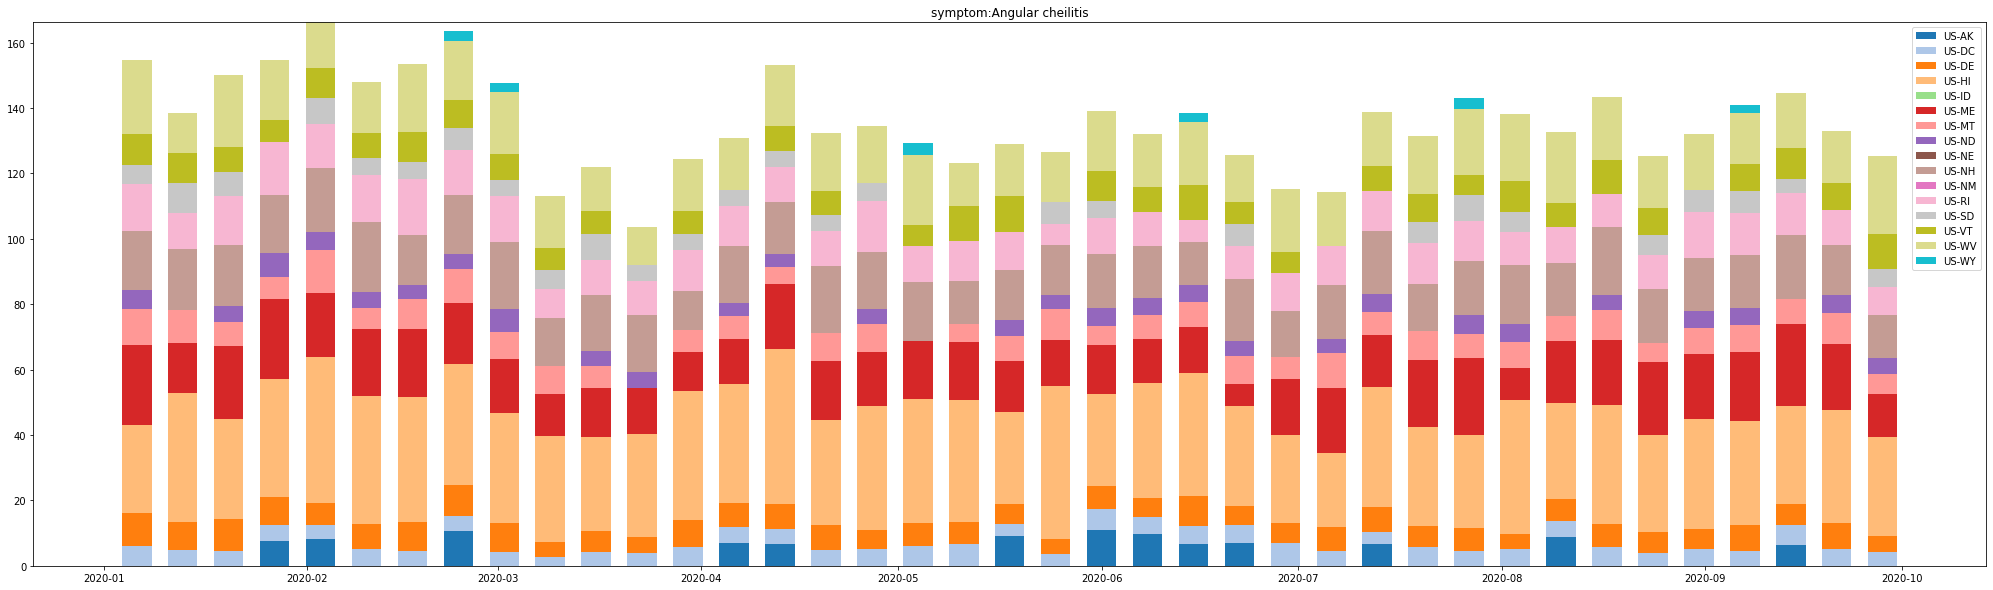

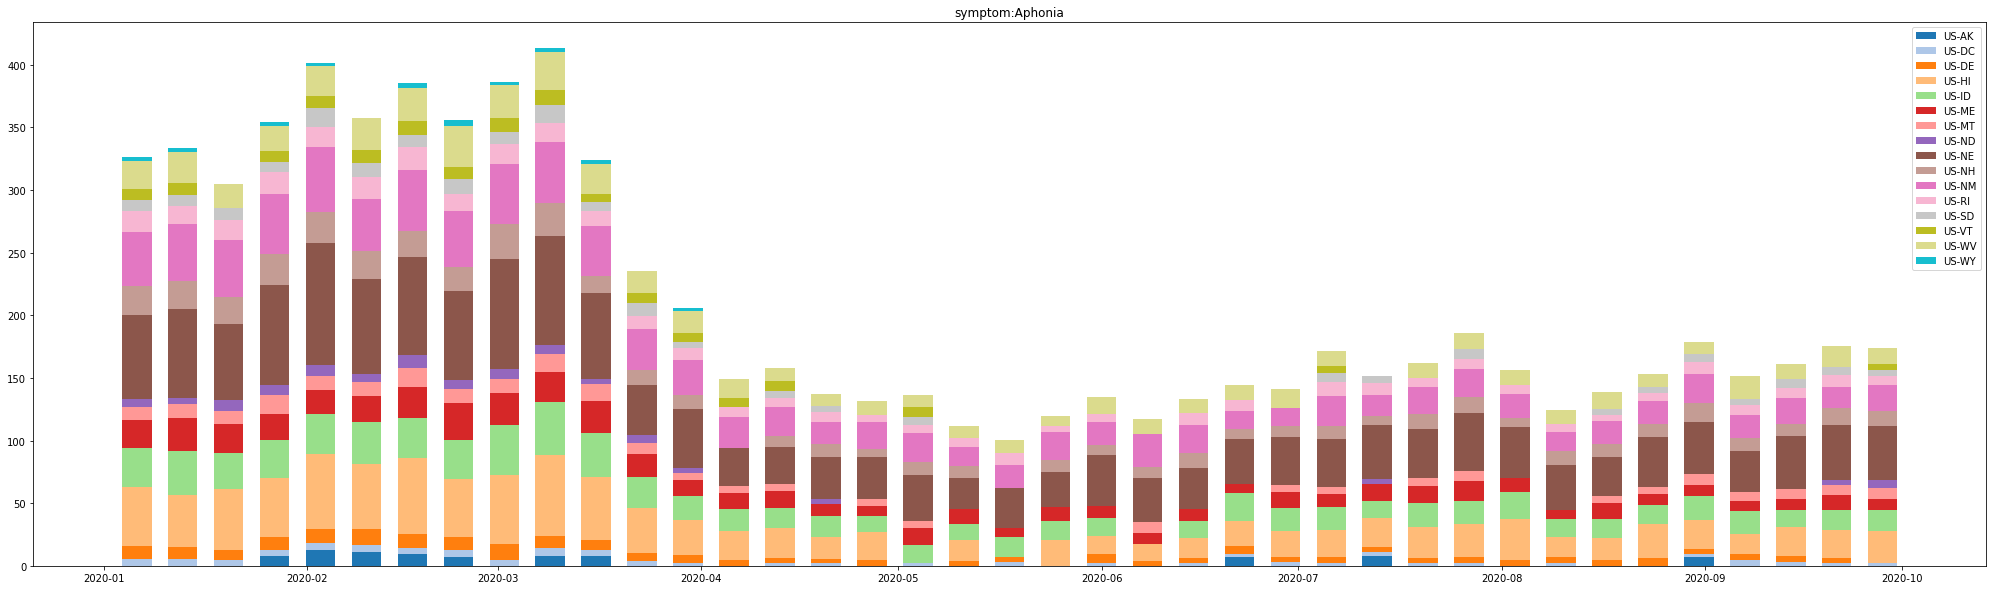

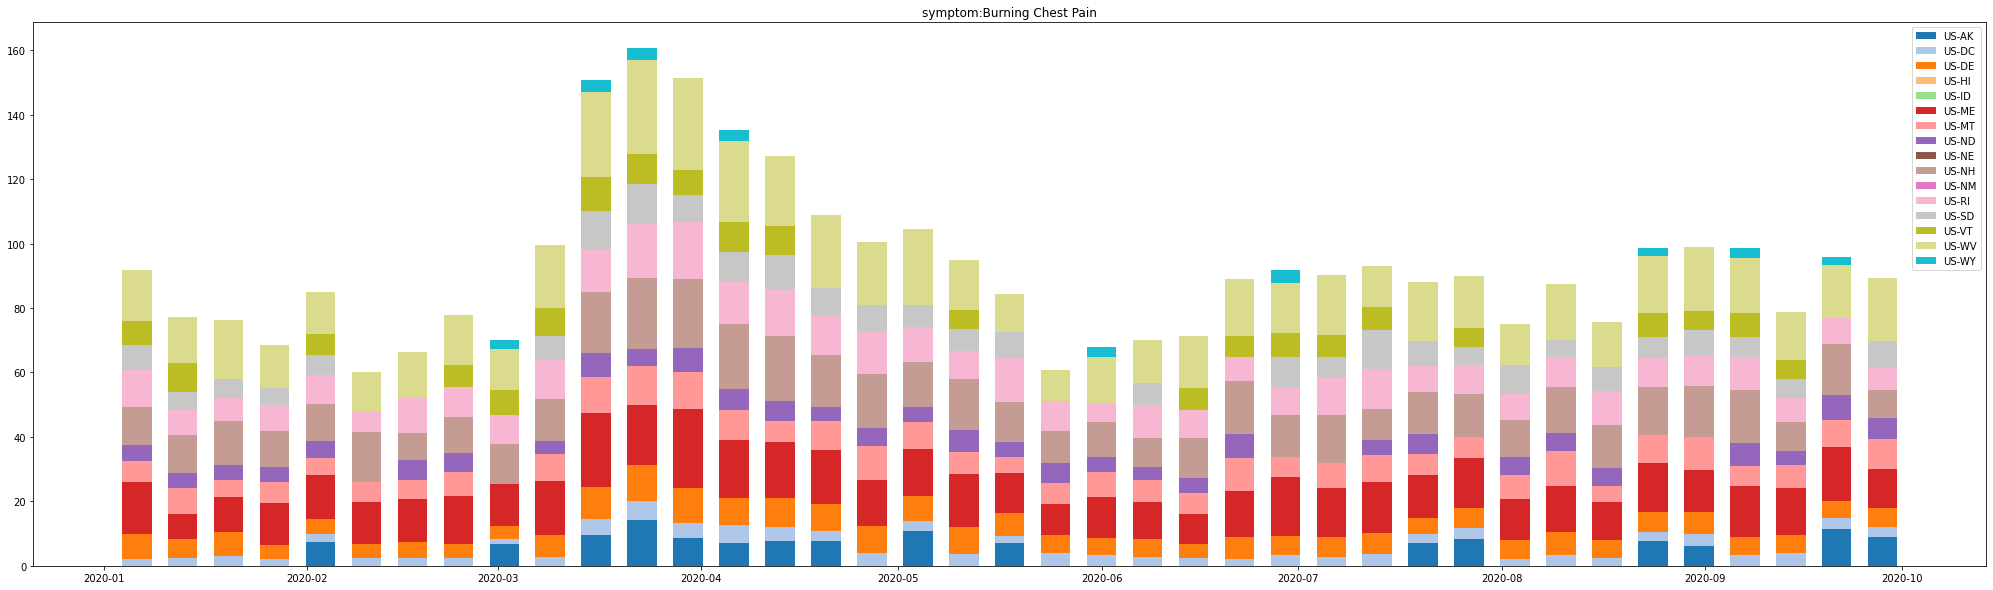

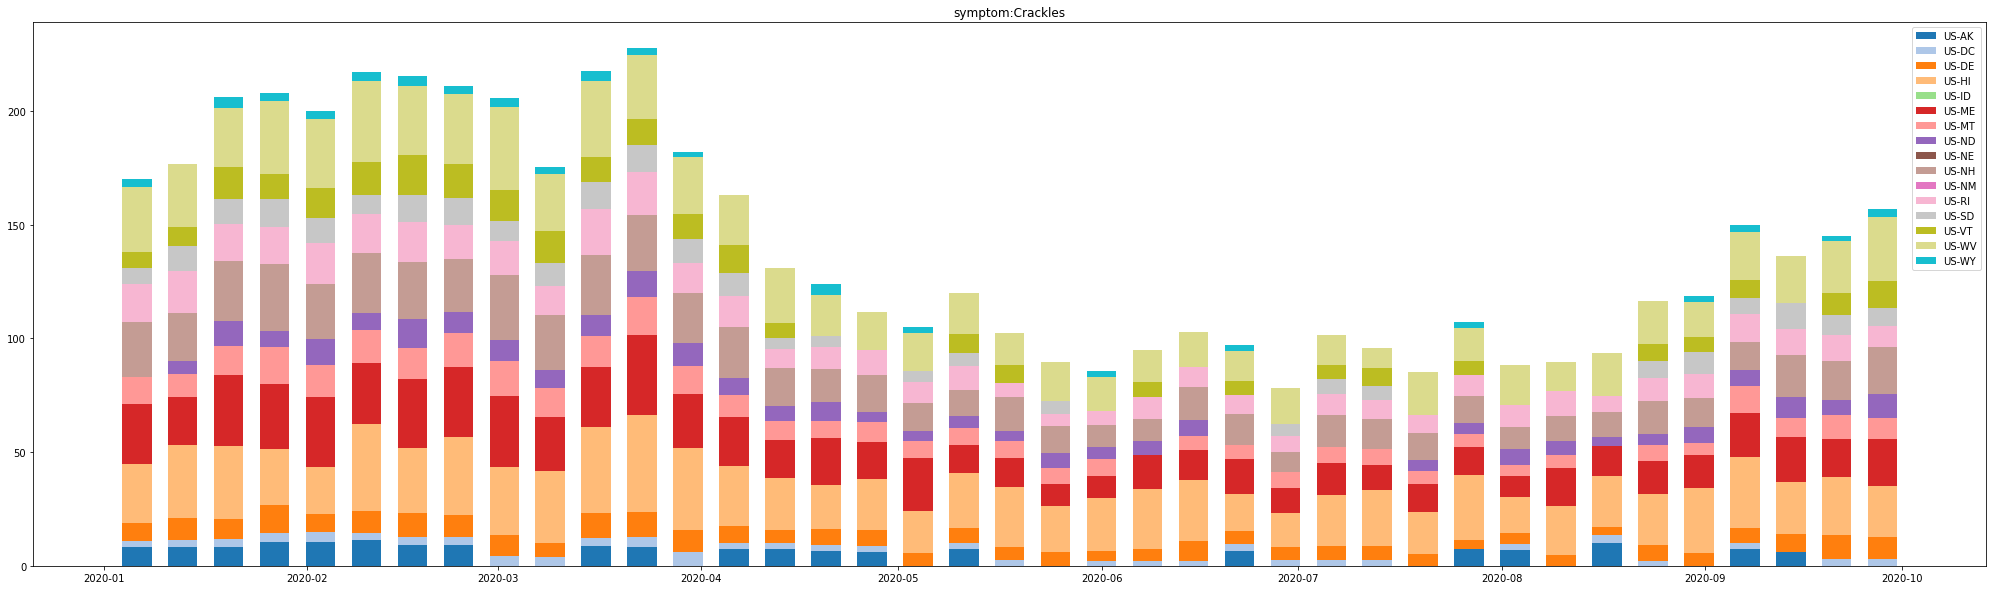

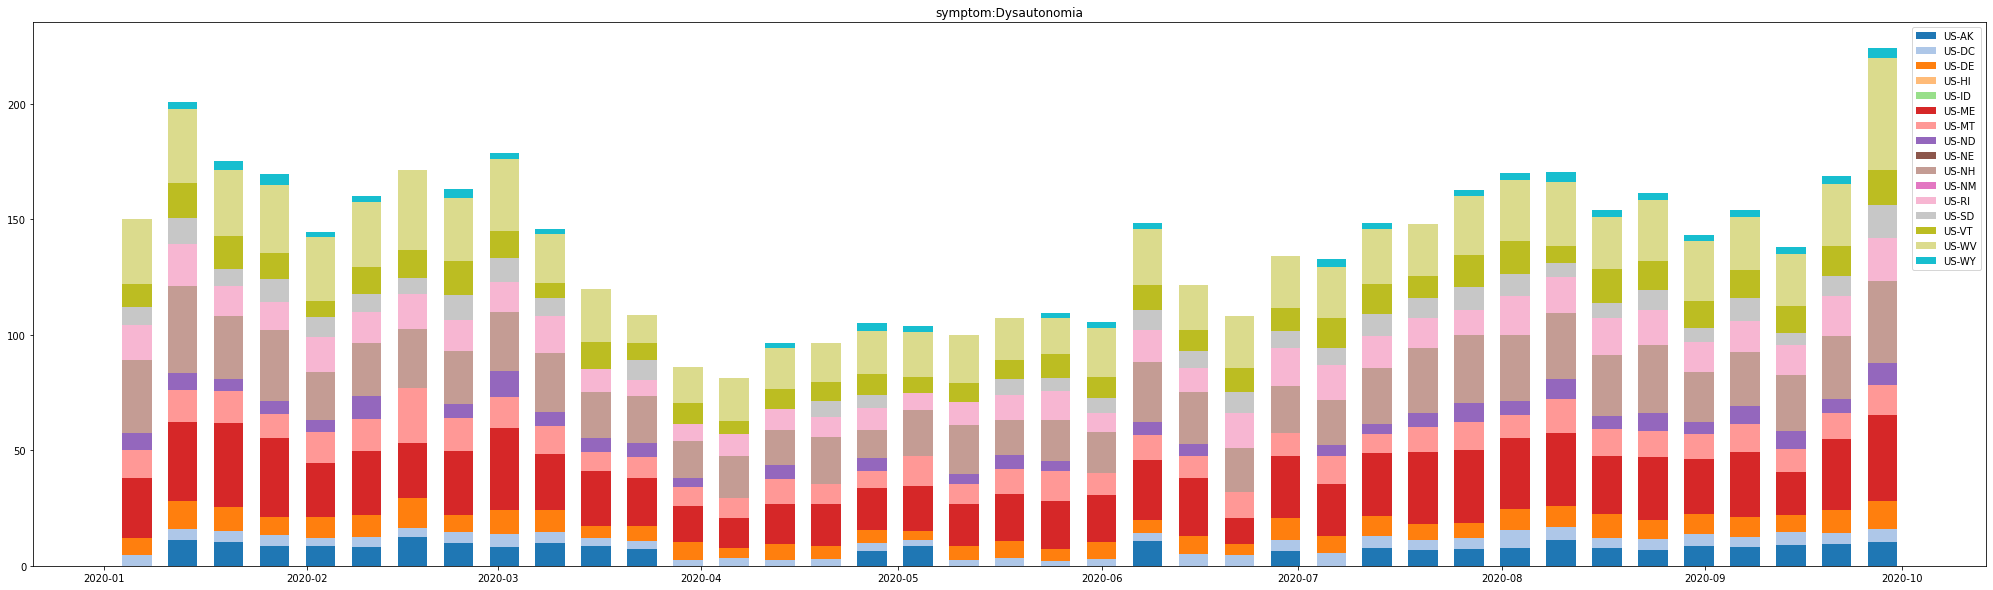

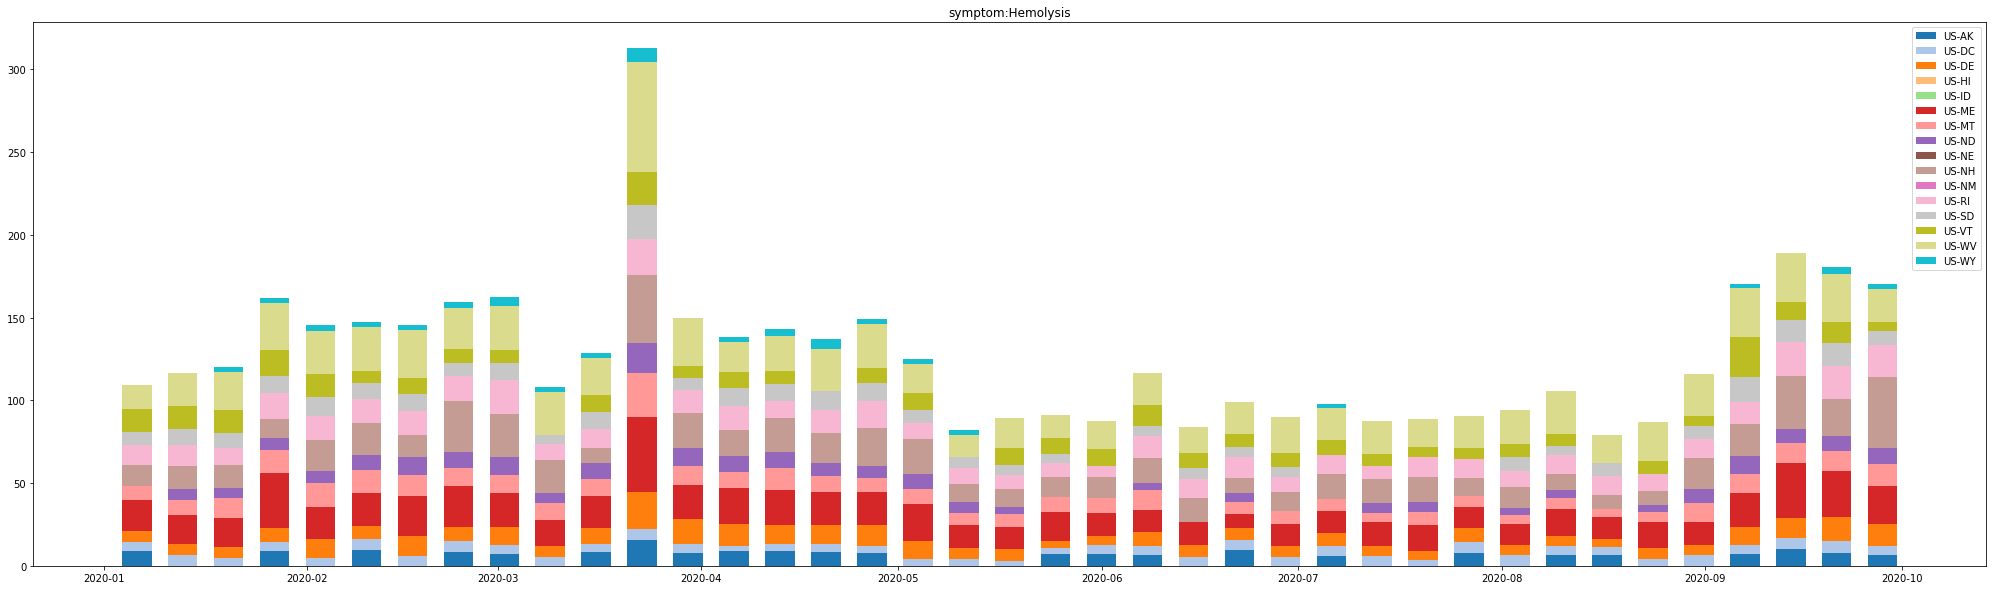

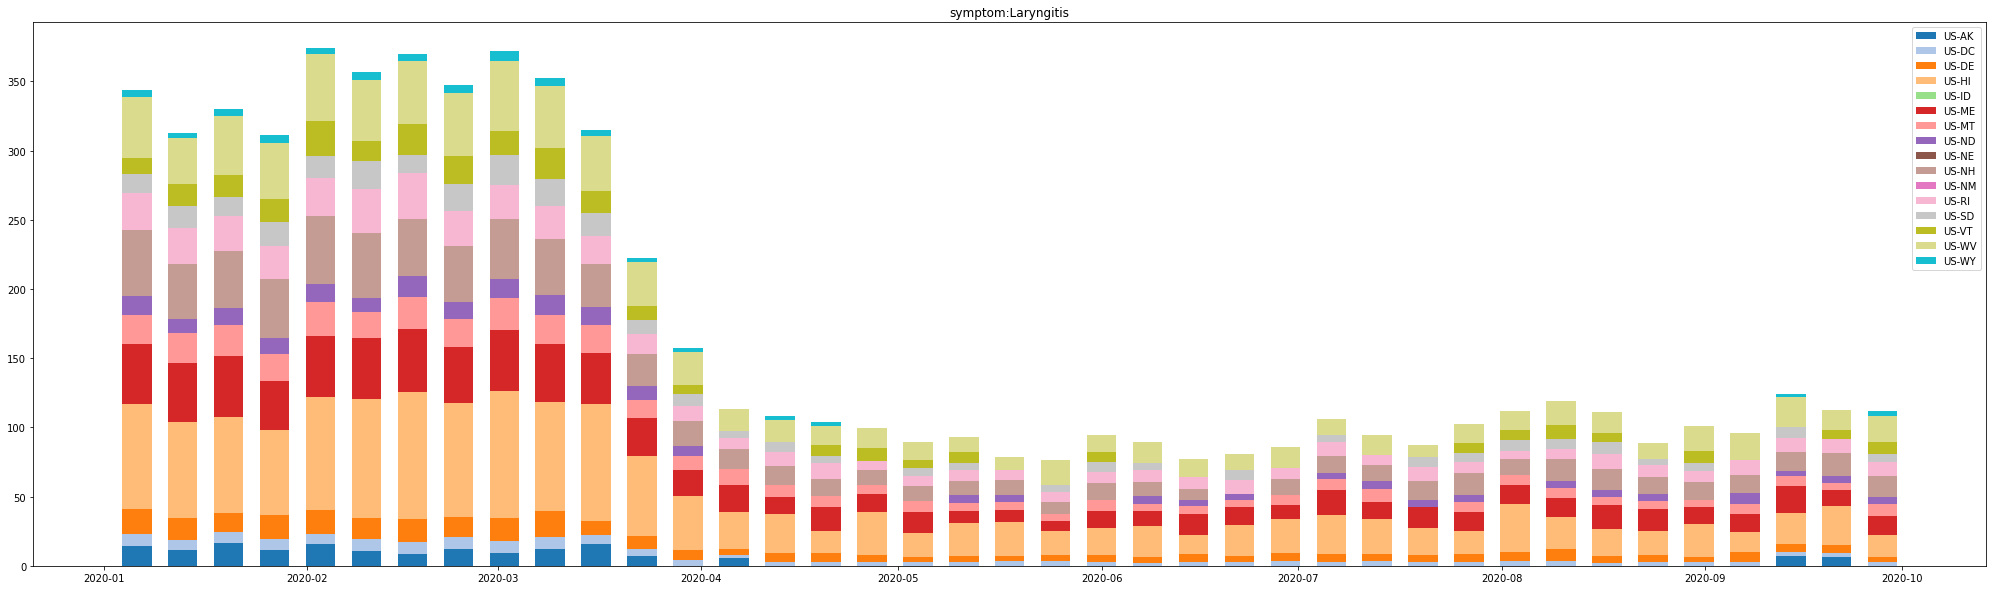

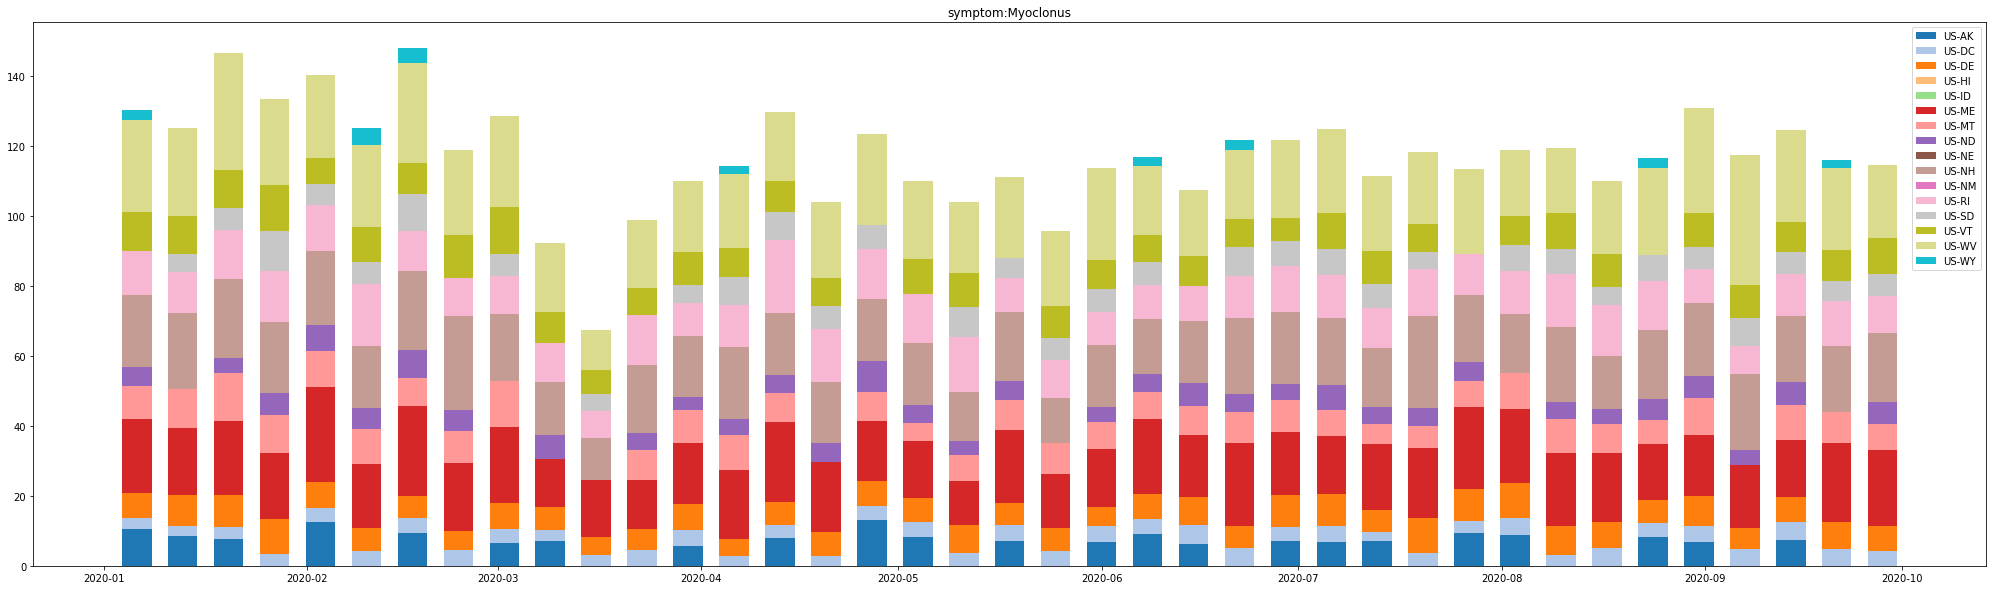

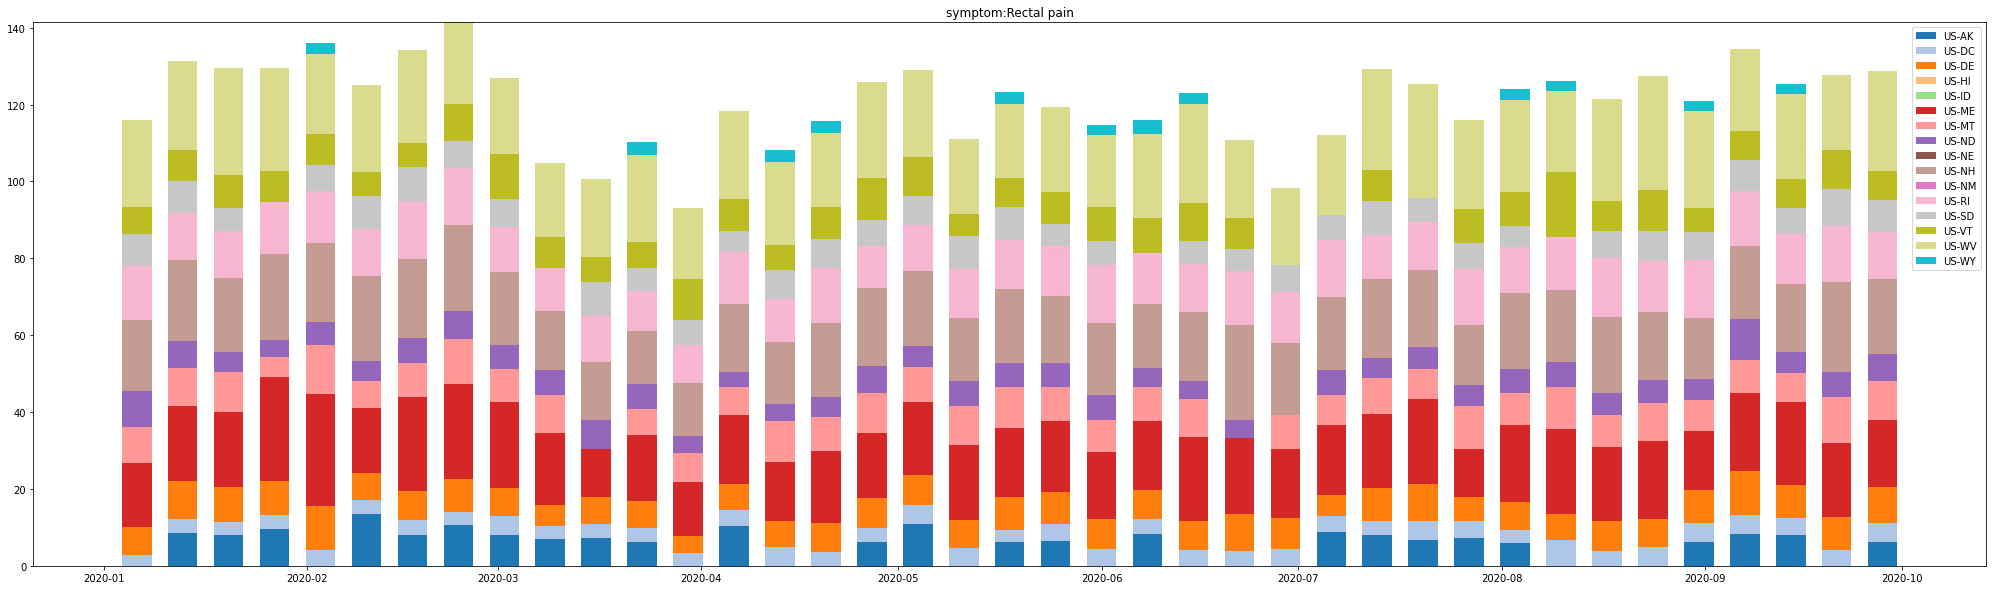

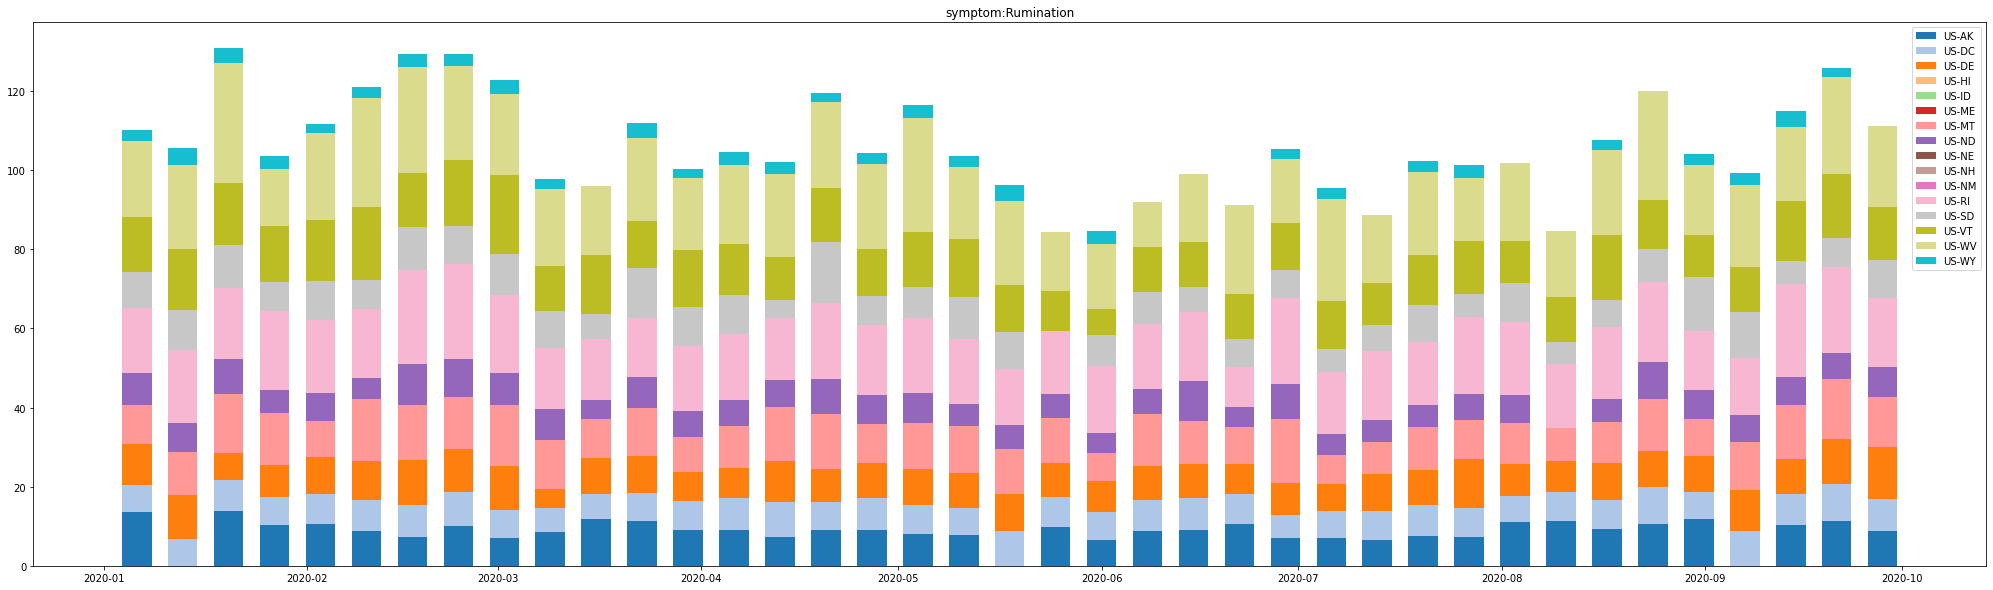

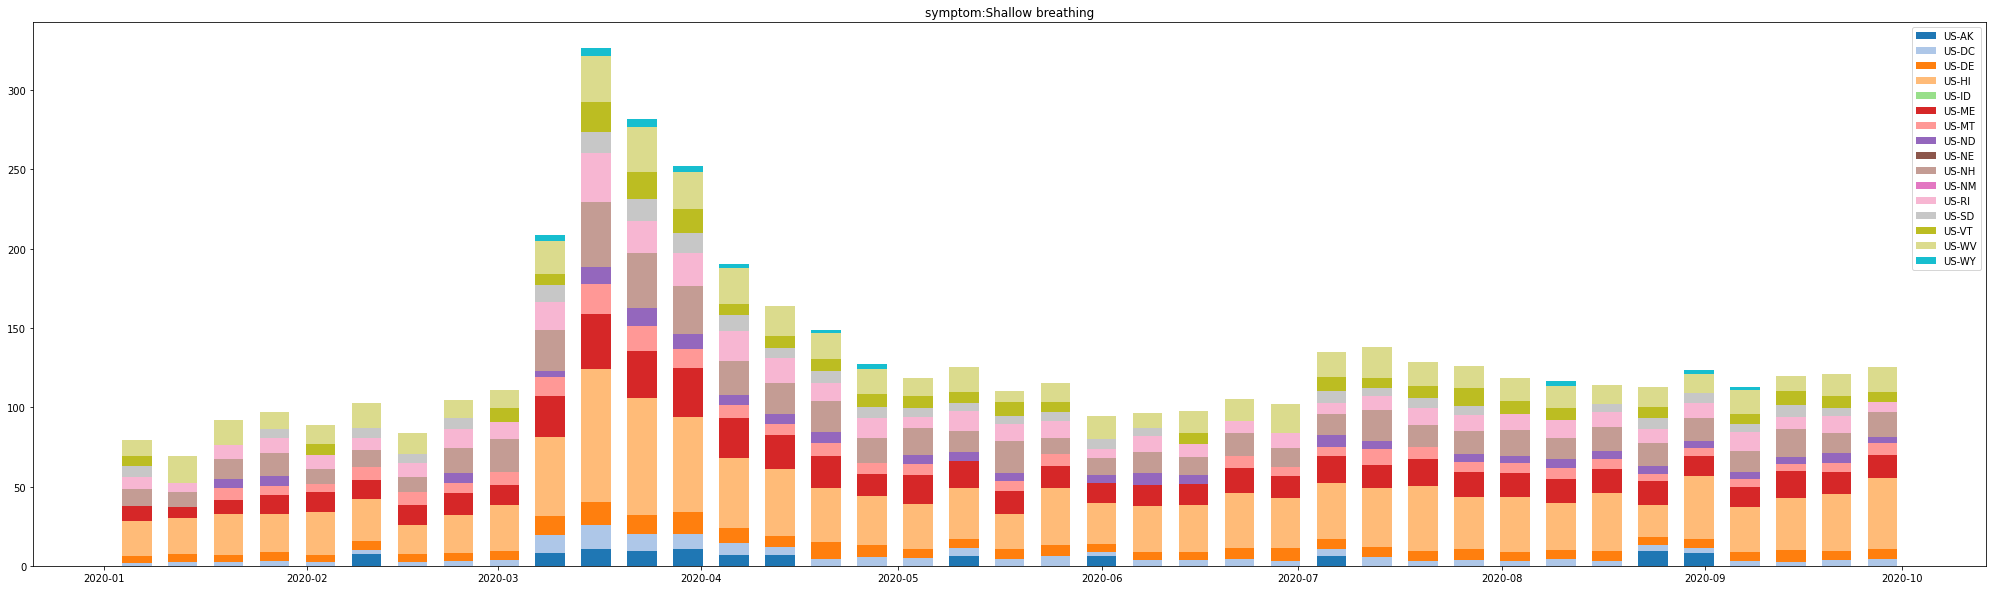

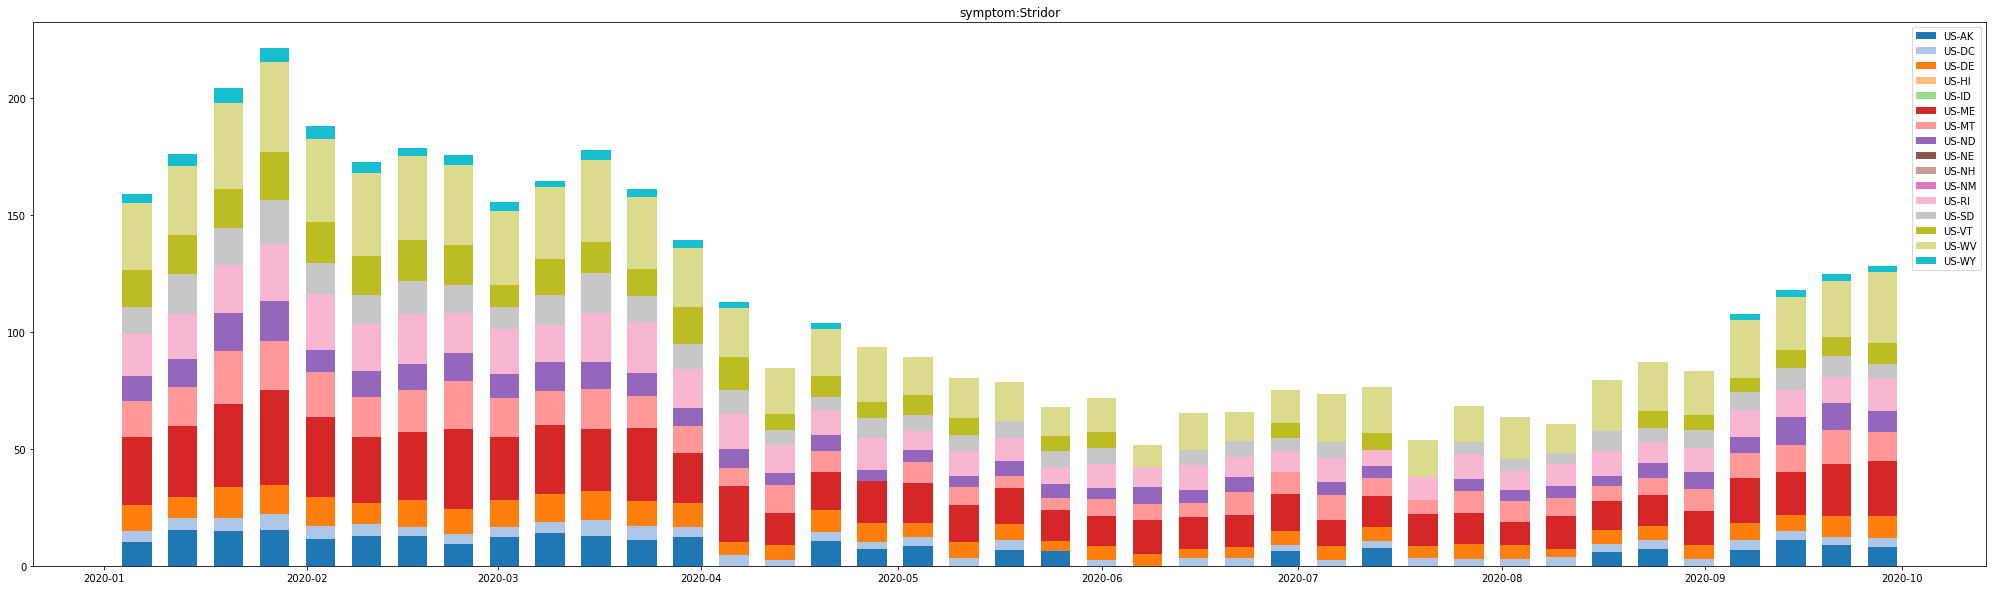

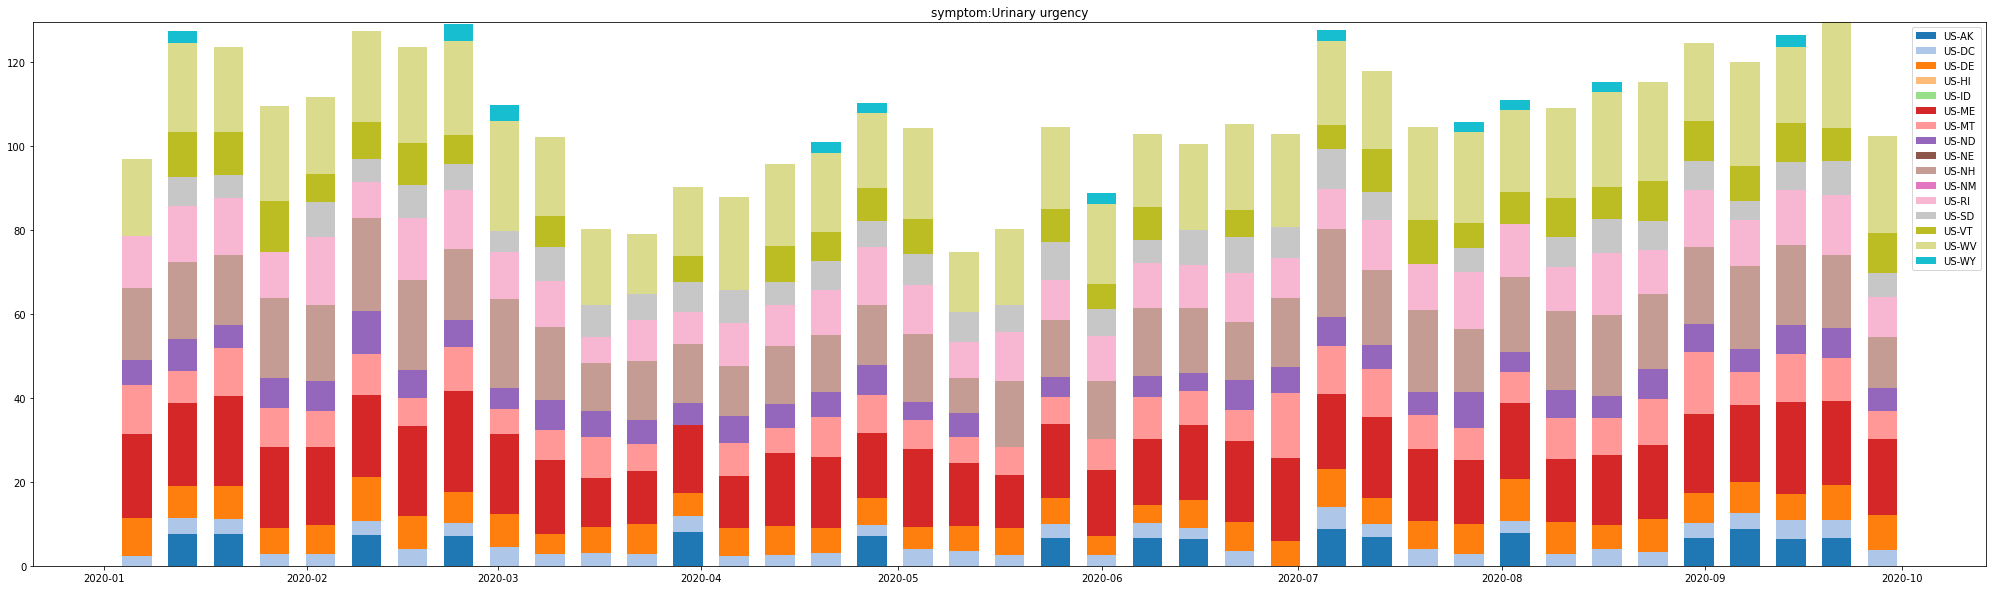

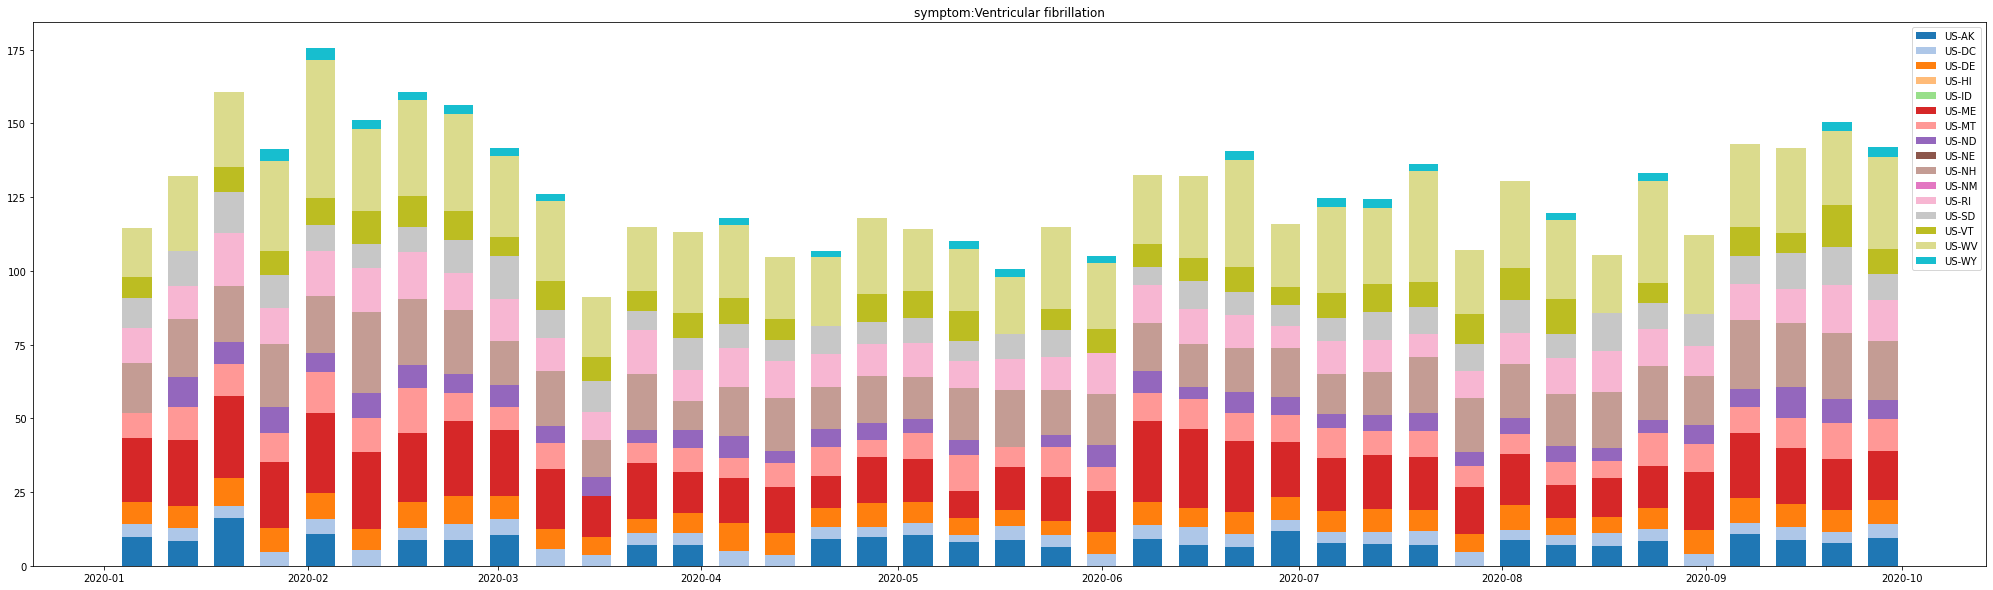

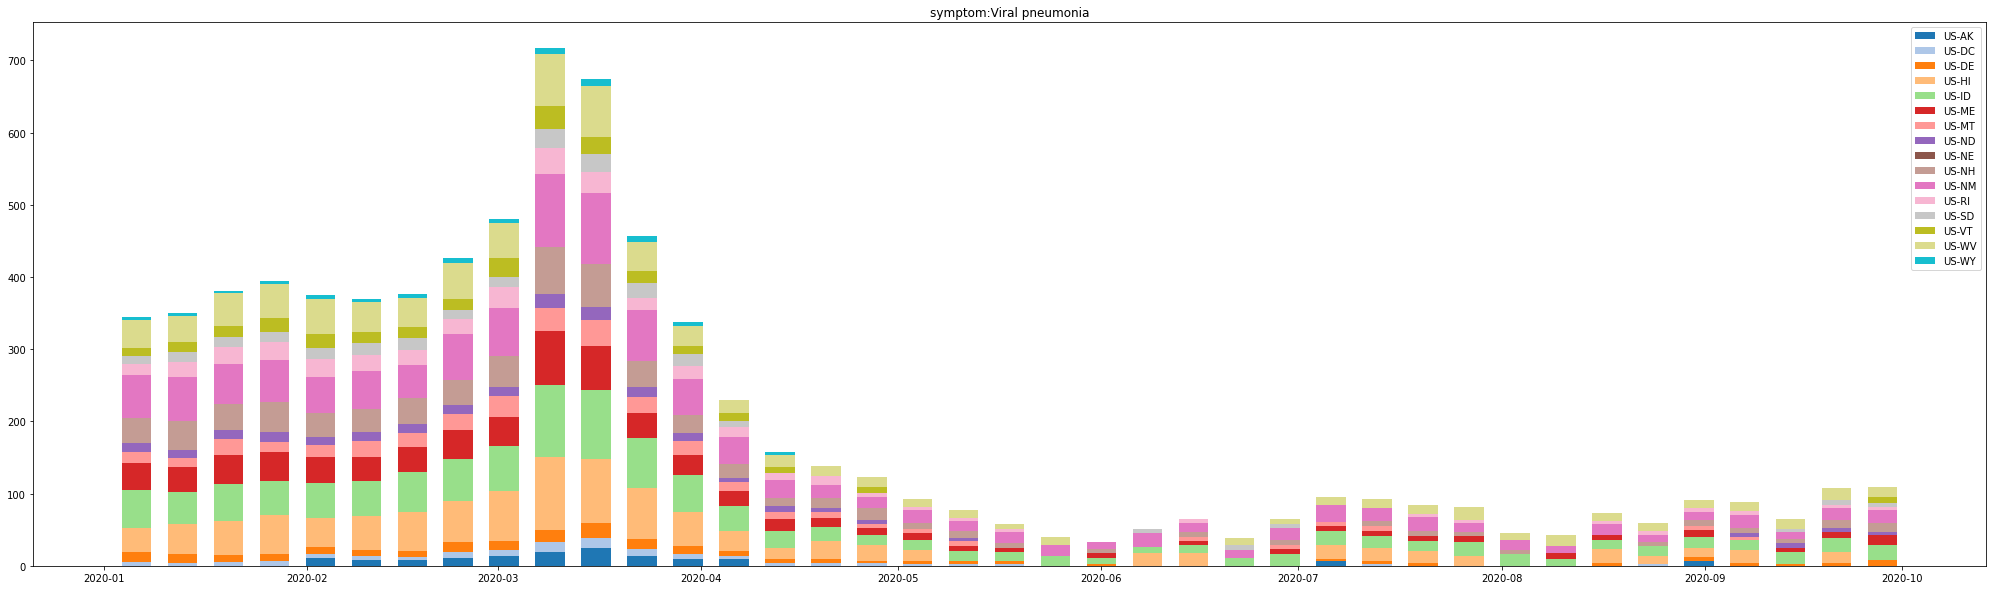

In [16]:
## extract all symptoms
symptoms = []
for column in mergedData.columns:
    type(column)
    if 'symptom' in column:
        ## column = column[8:]
        symptoms.append(column)

del column

## iteratively plot each symptoms
weeks = mergedData['date'].unique()
regions = mergedData['open_covid_region_code'].unique()
grouped_data_by_week = mergedData.groupby('date')
grouped_by_region = mergedData.groupby('open_covid_region_code')

## for each symptom, draw a graph
for symptom in symptoms:
    fig, ax = plt.subplots(figsize=(35, 10))
    NUM_COLORS = len(regions)
    color_map = plt.get_cmap('tab20')
    ax.set_prop_cycle('color', [color_map(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

    width = 4.5
    ## for each region, fetch data from each week
    previous_region_week_data = [0] * len(weeks) ## the bottom for the next region rect
    for region in regions:
        region_data_all_weeks = grouped_by_region.get_group(region)[symptom].fillna(0)
        ax.set_title(symptom)
        ax.bar(weeks, region_data_all_weeks, width, previous_region_week_data, label = region)
        ax.legend()
        ## update previous data
        region_data_list =region_data_all_weeks.to_list()
        for i in range(0, len(region_data_all_weeks)):
            previous_region_week_data[i] += region_data_list[i]

del symptoms
del weeks
del regions
del grouped_data_by_week

### PCA

In [24]:
searchTrendData

,open_covid_region_code,country_region_code,country_region,sub_region_1,sub_region_1_code,date,symptom:Angular cheilitis,symptom:Aphonia,symptom:Burning Chest Pain,symptom:Crackles,...,symptom:Hemolysis,symptom:Laryngitis,symptom:Myoclonus,symptom:Rectal pain,symptom:Rumination,symptom:Shallow breathing,symptom:Stridor,symptom:Urinary urgency,symptom:Ventricular fibrillation,symptom:Viral pneumonia
0,US-AK,US,United States,Alaska,US-AK,2020-01-06,NaN,NaN,NaN,8.33,...,9.12,14.47,10.51,NaN,13.68,NaN,10.31,NaN,9.91,NaN
1,US-AK,US,United States,Alaska,US-AK,2020-01-13,NaN,NaN,NaN,8.22,...,NaN,11.28,8.41,8.41,NaN,NaN,15.49,7.65,8.41,NaN
2,US-AK,US,United States,Alaska,US-AK,2020-01-20,NaN,NaN,NaN,8.28,...,NaN,16.38,7.73,7.91,13.98,NaN,14.90,7.54,16.19,NaN
3,US-AK,US,United States,Alaska,US-AK,2020-01-27,7.47,7.65,NaN,10.39,...,8.93,11.30,NaN,9.66,10.20,NaN,15.12,NaN,NaN,NaN
4,US-AK,US,United States,Alaska,US-AK,2020-02-03,8.06,12.56,7.50,10.31,...,NaN,15.93,12.56,NaN,10.50,NaN,11.43,NaN,10.68,10.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
619,US-WY,US,United States,Wyoming,US-WY,2020-08-31,NaN,NaN,NaN,2.85,...,NaN,NaN,NaN,2.63,2.85,2.9,NaN,NaN,NaN,NaN
620,US-WY,US,United States,Wyoming,US-WY,2020-09-07,2.25,NaN,3.36,2.75,...,2.53,NaN,NaN,NaN,2.86,2.2,2.48,NaN,NaN,NaN
621,US-WY,US,United States,Wyoming,US-WY,2020-09-14,NaN,NaN,NaN,NaN,...,NaN,2.19,NaN,2.46,3.88,NaN,2.57,2.68,NaN,NaN
622,US-WY,US,United States,Wyoming,US-WY,2020-09-21,NaN,NaN,2.52,2.52,...,4.38,NaN,2.41,NaN,2.24,NaN,2.74,NaN,3.23,NaN


In [26]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

le = LabelEncoder()
le.fit(searchTrendData.iloc[0:6,:])
le.classes_

#searchTrendPCA = ohe.fit_transform(searchTrendData)
#pca = PCA(n_components=2)
#searchTrendPCA = pca.fit_transform(searchTrendPCA)
#searchTrendPCA

TypeError: '(slice(0, 5, None), slice(None, None, None))' is an invalid key